# 7. Comparación modelos automatizado

Se ejecutan todos los modelos y se imprime:

* Comparación de métricas
* Tiempos de ejecución por modelo
* Matrices de confusión
* Importancia de características

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 67200, number of used features: 32
[LightGBM] [Info] Start training from score -2.351375
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -3.737670
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Info] Start training from score -1.252763
[LightGBM] [Info] Start training from score -1.945910


c:\Users\aanaj\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:50:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\aanaj\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Comparación de métricas:
           Logistic Regression  Random Forest  Decision Tree  \
Accuracy                 0.712           0.99          0.955   
Precision                0.710           0.99          0.955   
Recall                   0.712           0.99          0.955   
F1-score                 0.705           0.99          0.955   

           Gradient Boosting  LightGBM  XGBoost  Naive Bayes    SVM    KNN  
Accuracy               0.966     0.994    0.994        0.385  0.858  0.864  
Precision              0.966     0.994    0.994        0.725  0.845  0.867  
Recall                 0.966     0.994    0.994        0.385  0.858  0.864  
F1-score               0.966     0.994    0.994        0.484  0.850  0.865  

Tiempos de ejecución por modelo:
                Modelo  Tiempo (segundos)
7                  SVM        7256.935317
3    Gradient Boosting         479.963138
1        Random Forest          35.046237
5              XGBoost           5.886803
4             LightGBM   

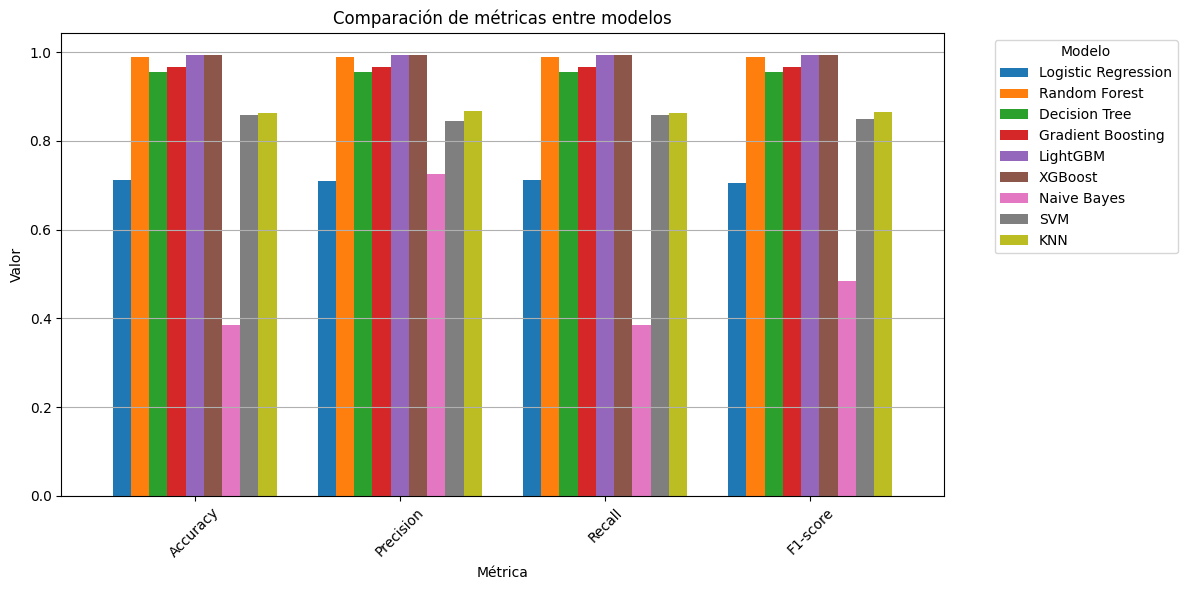

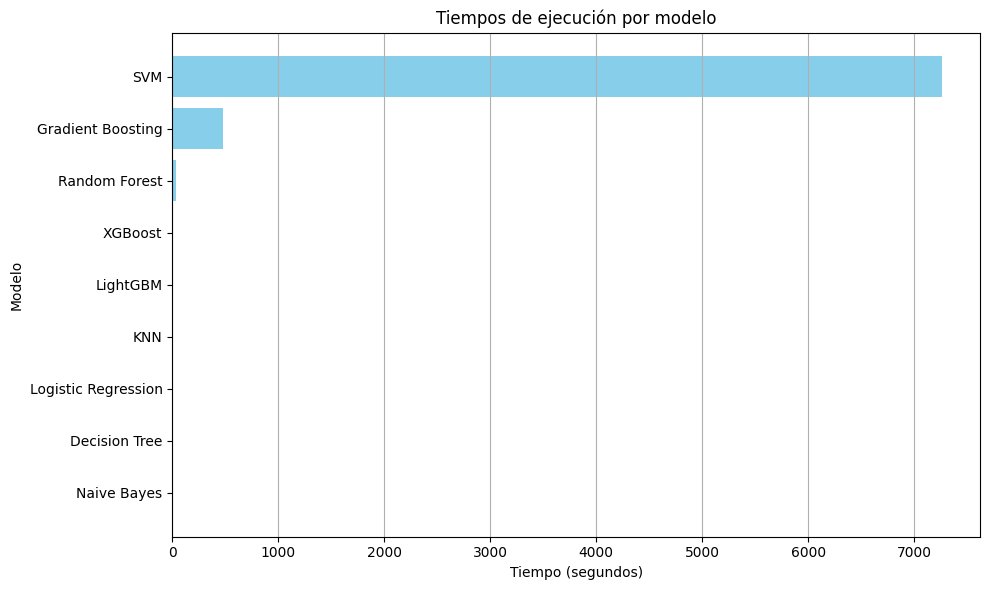

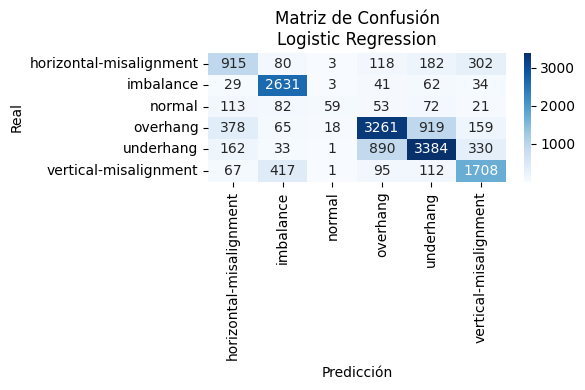

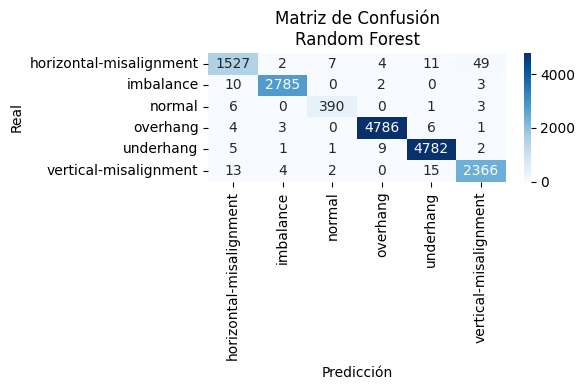

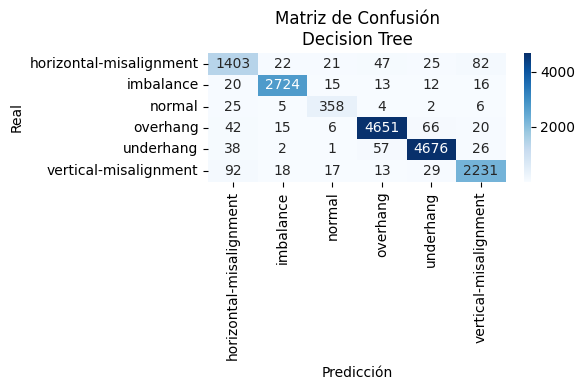

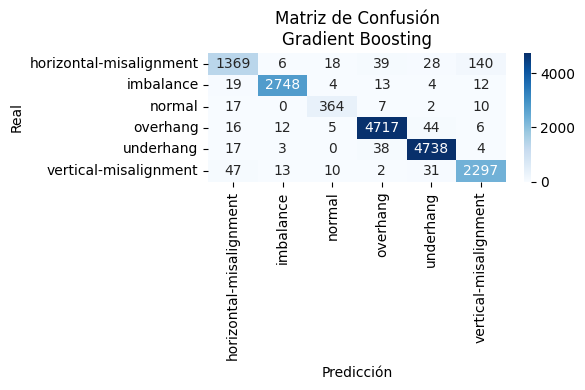

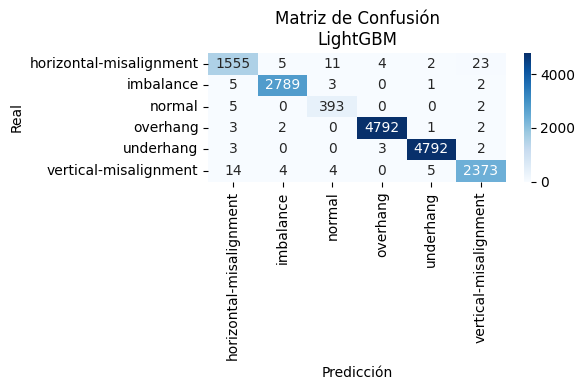

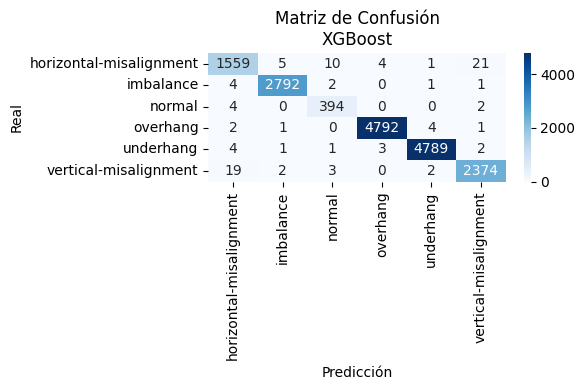

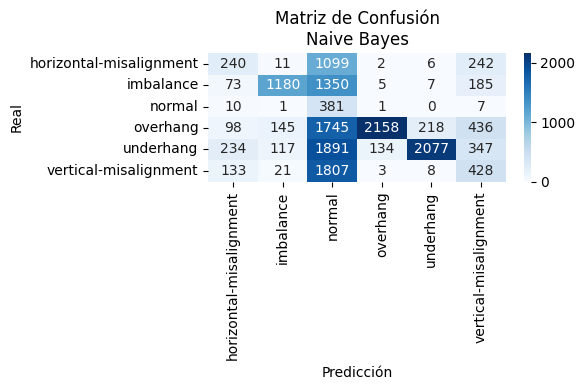

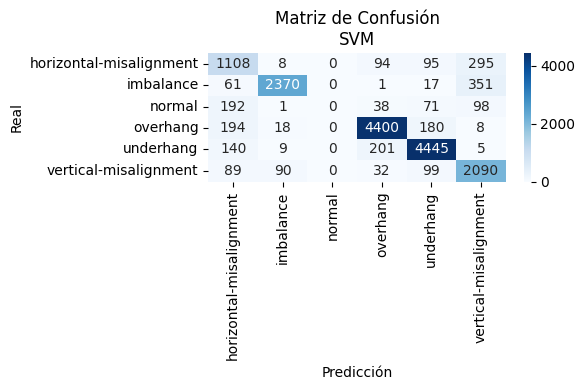

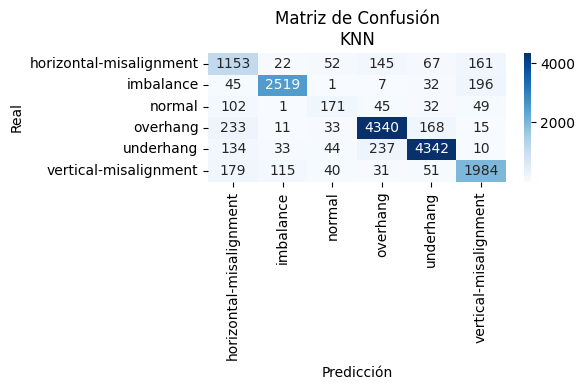

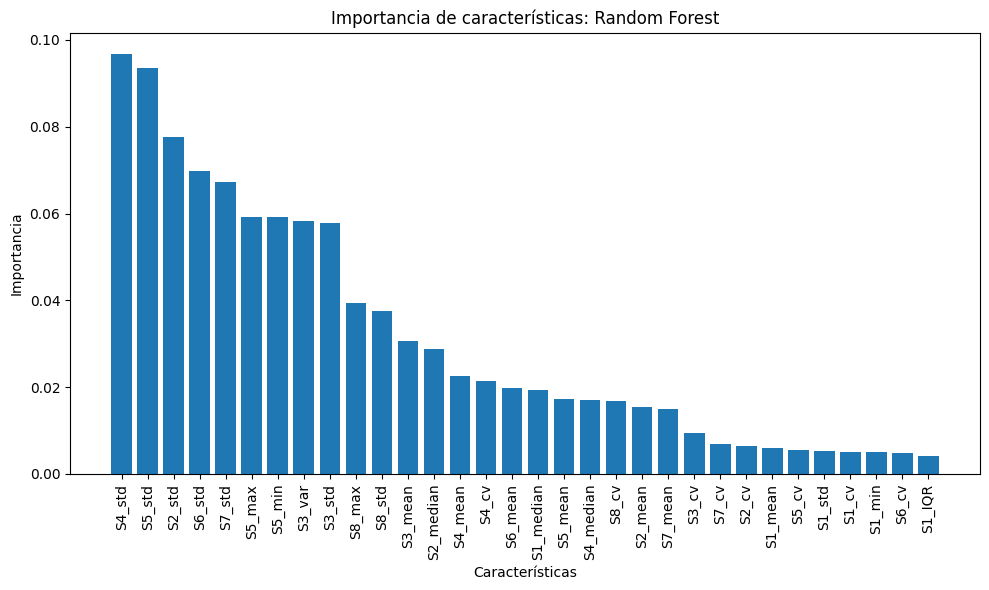

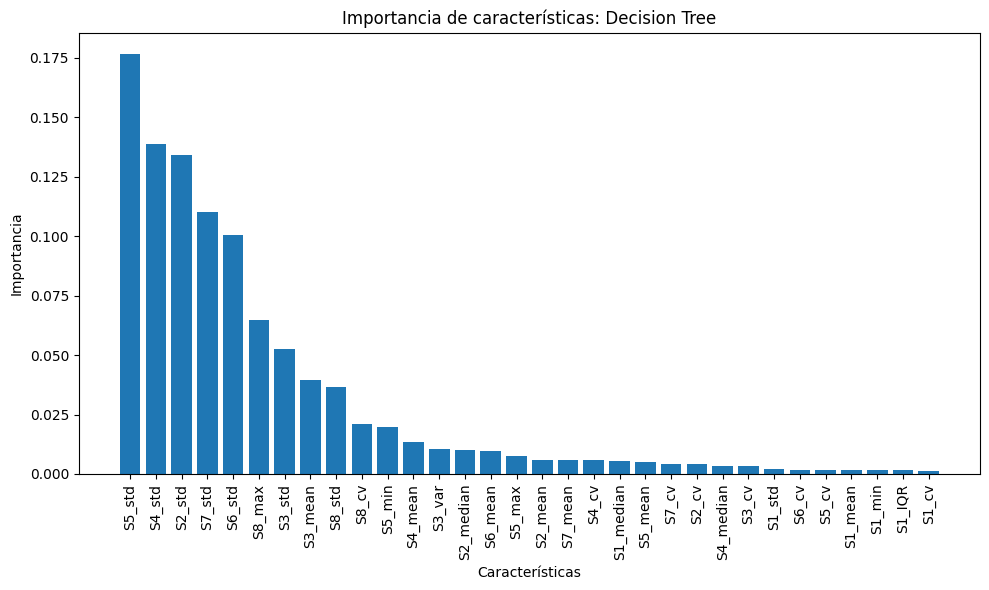

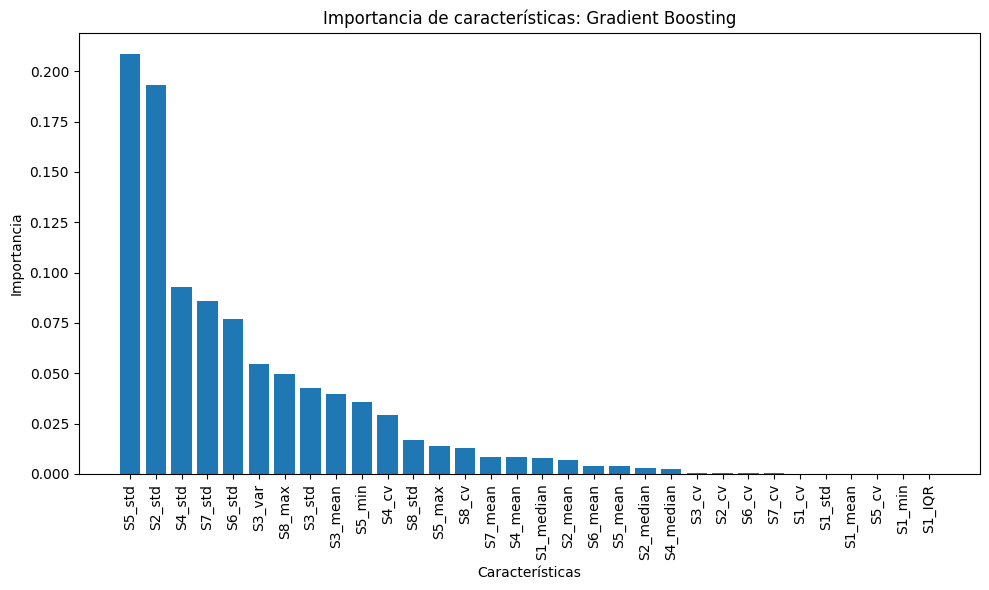

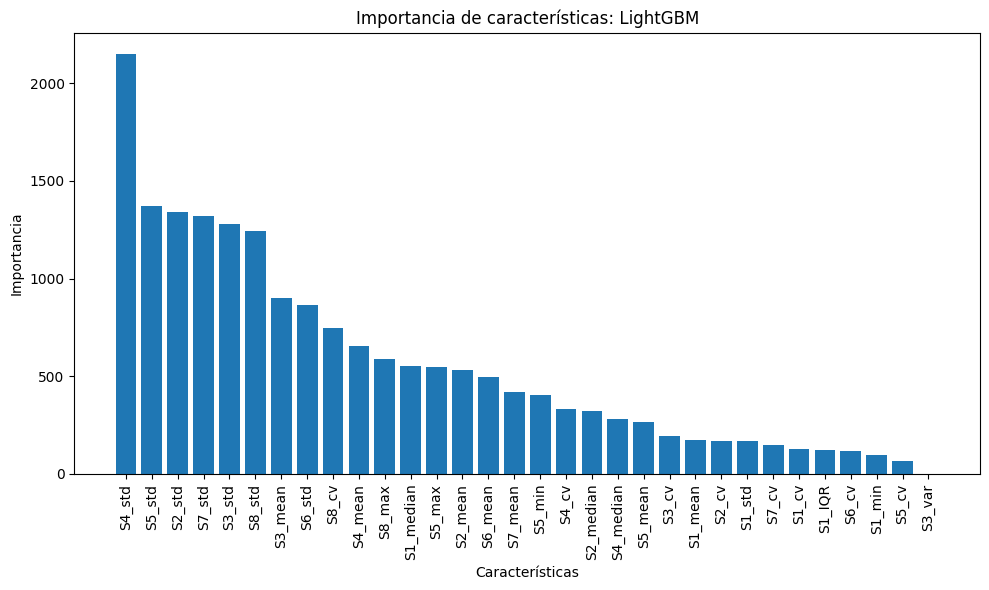

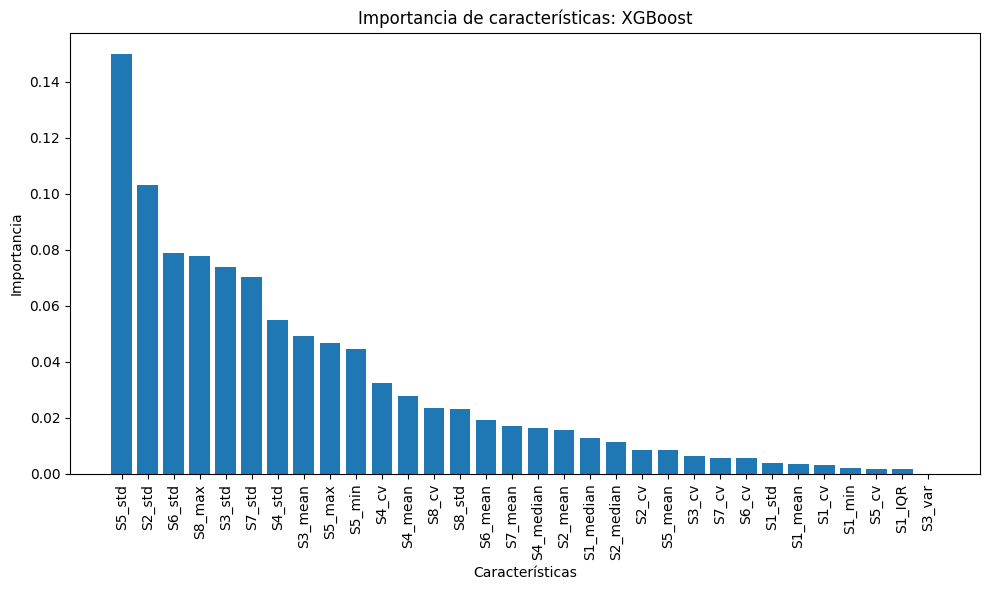

In [1]:
import pandas as pd
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("df_reduced.csv")

X = df.drop(columns=["Hz", "medida", "Tipo"])
y = df["Tipo"]

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), True),
    'Random Forest': (RandomForestClassifier(n_estimators=100, random_state=42), False),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), False),
    'Gradient Boosting': (GradientBoostingClassifier(n_estimators=100, random_state=42), False),
    'LightGBM': (lgb.LGBMClassifier(n_estimators=100, random_state=42), False),
    'XGBoost': (xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss'), False),
    'Naive Bayes': (GaussianNB(), False),
    'SVM': (SVC(probability=True, random_state=42), True),
    'KNN': (KNeighborsClassifier(n_neighbors=5), True)
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

metrics_dict = {}
times_dict = {}

for model_name, (model, needs_scaling) in models.items():
    start_time = time.time()
    
    if needs_scaling:
        X_train_input, X_test_input = X_train_scaled, X_test_scaled
    else:
        X_train_input, X_test_input = X_train, X_test

    model.fit(X_train_input, y_train)
    y_pred = model.predict(X_test_input)
    y_prob = model.predict_proba(X_test_input) if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=1),
        'F1-score': f1_score(y_test, y_pred, average='weighted')
    }
    metrics_dict[model_name] = metrics
    times_dict[model_name] = time.time() - start_time

metrics_df = pd.DataFrame(metrics_dict).round(3)
print("Comparación de métricas:")
print(metrics_df)

times_df = pd.DataFrame(list(times_dict.items()), columns=['Modelo', 'Tiempo (segundos)'])
times_df = times_df.sort_values(by='Tiempo (segundos)', ascending=False)
print("\nTiempos de ejecución por modelo:")
print(times_df)

metrics_df.plot(kind='bar', figsize=(12, 6), width=0.8)
plt.title('Comparación de métricas entre modelos')
plt.xlabel('Métrica')
plt.ylabel('Valor')
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.barh(times_df['Modelo'], times_df['Tiempo (segundos)'], color='skyblue')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Modelo')
plt.title('Tiempos de ejecución por modelo')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(title)
    plt.ylabel('Real')
    plt.xlabel('Predicción')
    plt.tight_layout()

for model_name, (model, needs_scaling) in models.items():
    if needs_scaling:
        X_test_input = X_test_scaled
    else:
        X_test_input = X_test

    y_pred = model.predict(X_test_input)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    plot_confusion_matrix(conf_matrix, f'Matriz de Confusión\n{model_name}')
    plt.show()

for model_name, (model, needs_scaling) in models.items():
    if hasattr(model, 'feature_importances_'):
        feature_importances = model.feature_importances_
        sorted_idx = feature_importances.argsort()[::-1]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
        plt.xticks(range(len(sorted_idx)), X.columns[sorted_idx], rotation=90)
        plt.title(f'Importancia de características: {model_name}')
        plt.xlabel('Características')
        plt.ylabel('Importancia')
        plt.tight_layout()
        plt.show()
